# Light Curtain Sweep Dataset

This code here shows you how to load data from the sweep dataset and visualize it. The sweep dataset consists of 600 images consisting of Lidar, Stereo and Light Curtain sweep data (3m to 18m at 0.1m intervals). With this sweep volume, you can "simulate" a real light curtain

In [6]:
# Python
import numpy as np
import time
import cv2
import math
import copy
import sys
sys.path.append("../")
sys.path.append("../external/lcsim/python")

# Custom
try:
    import kittiloader.kitti as kitti
    import kittiloader.batch_loader as batch_loader
except:
    import kitti
    import batch_loader

# Data Loading Module
import torch.multiprocessing
import torch.multiprocessing as mp
from torch.multiprocessing import Process, Queue, Value, cpu_count
import utils.img_utils as img_utils
import utils.misc_utils as misc_utils
import external.utils_lib.utils_lib as kittiutils
import torch.nn.functional as F
import json
from easydict import EasyDict
import warping.view as View
import torchvision.transforms as transforms
from models.get_model import get_model
from utils.torch_utils import bias_parameters, weight_parameters, \
    load_checkpoint, save_checkpoint, AdamW
from lc import light_curtain
from external.perception_lib import viewer
import ipyvolume.pylab as p3
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from matplotlib import interactive
interactive(True)
%matplotlib notebook

In [7]:
def load_datum(path, name, indx):
    datum = dict()
    # Generate Paths
    date = name.split("_drive")[0]
    index_str = "%06d" % (indx,)
    sweep_path = path + "/" + date + "/" + name + "/sweep/" + index_str + ".npy"
    left_img_path = path + "/" + date + "/" + name + "/left_img/" + index_str + ".png"
    right_img_path = path + "/" + date + "/" + name + "/right_img/" + index_str + ".png"
    nir_img_path = path + "/" + date + "/" + name + "/nir_img/" + index_str + ".png"
    velo_path = path + "/" + date + "/" + name + "/lidar/" + index_str + ".bin"
    json_path = path + "/" + date + "/" + name + "/calib.json"

    # Load Data
    datum["sweep_arr"] = np.load(sweep_path).astype(np.float32)
    datum["velodata"] = np.fromfile(velo_path, dtype=np.float32).reshape((-1, 4))
    datum["left_img"] = cv2.imread(left_img_path)
    datum["right_img"] = cv2.imread(right_img_path)
    datum["nir_img"] = cv2.imread(nir_img_path)
    datum["nir_img"] = cv2.cvtColor(datum["nir_img"], cv2.COLOR_BGR2GRAY)
    datum["left_img"] = cv2.resize(datum["left_img"], None, fx=0.25, fy=0.25, interpolation=cv2.INTER_AREA)
    datum["nir_img"] = cv2.resize(datum["nir_img"], None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
    datum["right_img"] = cv2.resize(datum["right_img"], None, fx=0.25, fy=0.25, interpolation=cv2.INTER_AREA)
    # Load Json
    with open(json_path) as json_file:
        calib = json.load(json_file)
    datum["large_intr"] = np.array(calib["left_P"]).astype(np.float32) / 4.
    datum["large_intr"][2,2] = 1.
    datum["M_velo2left"] = np.linalg.inv(np.array(calib["left_2_lidar"]).astype(np.float32))
    datum["large_size"] = [datum["left_img"].shape[1], datum["left_img"].shape[0]]
    datum["M_left2right"] = np.array(calib["left_2_right"]).astype(np.float32)
    datum["M_right2left"] = np.linalg.inv(datum["M_left2right"])
    datum["M_left2LC"] = np.array(calib["left_2_lc"]).astype(np.float32)
    datum["M_right2LC"] = np.matmul(datum["M_right2left"], datum["M_left2LC"])
    datum["D_lc"] = np.array([-0.033918, 0.027494, -0.001691, -0.001078, 0.000000]).astype(np.float32)
    datum["K_lc"] = np.array([
        [893.074542/2, 0.000000, 524.145998/2],
        [0.000000, 893.177518/2, 646.766885/2],
        [0.000000, 0.000000, 1.000000]
    ]).astype(np.float32)
    datum["K_lc"] /= 2
    datum["K_lc"][2,2] = 1.
    datum["lc_size"] = [256, 320]
    # datum["lc_size"] = [512, 640]
    datum["M_velo2right"] = np.matmul(datum["M_left2right"], datum["M_velo2left"])
    datum["M_velo2LC"] = np.matmul(datum["M_left2LC"], datum["M_velo2left"])
    datum["d_candi"] = img_utils.powerf(3, 18, 64, 1.)
    datum["d_candi_up"] = img_utils.powerf(3, 18, 128, 1.)
    datum["M_LC2laser"] = np.array([
        [0.999998660642566, -0.001633815794167618, 0.0000012624935166435589, 0.19989228458449756],
        [0.001633815794167618, 0.9999974722179782, -0.0015454518952038837, 0.00034823987032651596],
        [0.0000012624935166435595, 0.0015454518952038839, 0.9999988015754122, -0.014010022846647934],
        [0,0,0,1]
    ]).astype(np.float32)
    datum["M_LC2left"] = np.linalg.inv(datum["M_left2LC"])

    # Try to double the size of sweep_arr 
    sweep_arr_large = np.zeros((datum["sweep_arr"].shape[0], datum["sweep_arr"].shape[1]*2, datum["sweep_arr"].shape[2]*2, datum["sweep_arr"].shape[3]))
    for i in range(0, sweep_arr_large.shape[0]):
        sweep_arr_large[i,:,:,0] = cv2.resize(datum["sweep_arr"][i,:,:,0], None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
        sweep_arr_large[i,:,:,1] = cv2.resize(datum["sweep_arr"][i,:,:,1], None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    datum["sweep_arr_large"] = sweep_arr_large
    datum["K_lc_large"] = datum["K_lc"]*2
    datum["K_lc_large"][2,2] = 1.
    datum["lc_size_large"] = [512, 640]
    datum["nir_img_large"] = cv2.imread(nir_img_path)
    datum["nir_img_large"] = cv2.cvtColor(datum["nir_img_large"], cv2.COLOR_BGR2GRAY)

    # Easydict
    datum = EasyDict(datum)
    return datum

## We load some data from our sweep curtain dataset

In [8]:
# Load (Be sure to download from http://megatron.sp.cs.cmu.edu/raaj/data3/Public/raaj/sweep_data.zip)
datum = load_datum("/media/raaj/Storage/sweep_data", "2021_03_05_drive_0004_sweep", 10)
#datum = load_datum("/media/raaj/Storage/sweep_data", "2021_03_12_drive_0004_sweep", 81)
#datum = load_datum("/media/raaj/Storage/sweep_data", "2021_03_12_drive_0004_sweep", 42)

In [9]:
# Undistort Sweep Arr (only small one)
datum.nir_img = cv2.undistort(datum.nir_img, datum.K_lc, datum.D_lc)
for i in range(0, datum.sweep_arr.shape[0]):
    datum.sweep_arr[i, :,:, 0] = cv2.undistort(datum.sweep_arr[i, :,:, 0], datum.K_lc, datum.D_lc)
    datum.sweep_arr[i, :,:, 1] = cv2.undistort(datum.sweep_arr[i, :,:, 1], datum.K_lc, datum.D_lc)

# Depths
large_params = {"filtering": 2, "upsample": 0}
datum["left_depth"] = kittiutils.generate_depth(datum.velodata, datum.large_intr, datum.M_velo2left, datum.large_size[0], datum.large_size[1], large_params)
datum["right_depth"] = kittiutils.generate_depth(datum.velodata, datum.large_intr, datum.M_velo2right, datum.large_size[0], datum.large_size[1], large_params)
datum["lc_depth"] = kittiutils.generate_depth(datum.velodata, datum.K_lc, datum.M_velo2LC, datum.lc_size[0], datum.lc_size[1], large_params)
datum["lc_depth_large"] = kittiutils.generate_depth(datum.velodata, datum.K_lc_large, datum.M_velo2LC, datum.lc_size_large[0], datum.lc_size_large[1], large_params)

# # Upsample Depth
# datum.left_depth = kittiutils.upsample_depth(datum.left_depth, 2, 0.5)
# datum.right_depth = kittiutils.upsample_depth(datum.right_depth, 2, 0.5)
# datum.lc_depth = kittiutils.upsample_depth(datum.lc_depth, 2, 0.5)
# datum.lc_depth_large = kittiutils.upsample_depth(datum.lc_depth_large, 2, 0.5)

# Need this for simulated depth (ignore this)
pool_val = 4
datum.lc_depth_large = img_utils.minpool(torch.Tensor(datum.lc_depth_large).unsqueeze(0).unsqueeze(0), pool_val, 1000).squeeze(0).squeeze(0).numpy()
datum.lc_depth_large = cv2.resize(datum.lc_depth_large, (0,0), fx=pool_val, fy=pool_val, interpolation = cv2.INTER_NEAREST)

## Visualize the light curtain sweep volume

<IPython.core.display.Javascript object>


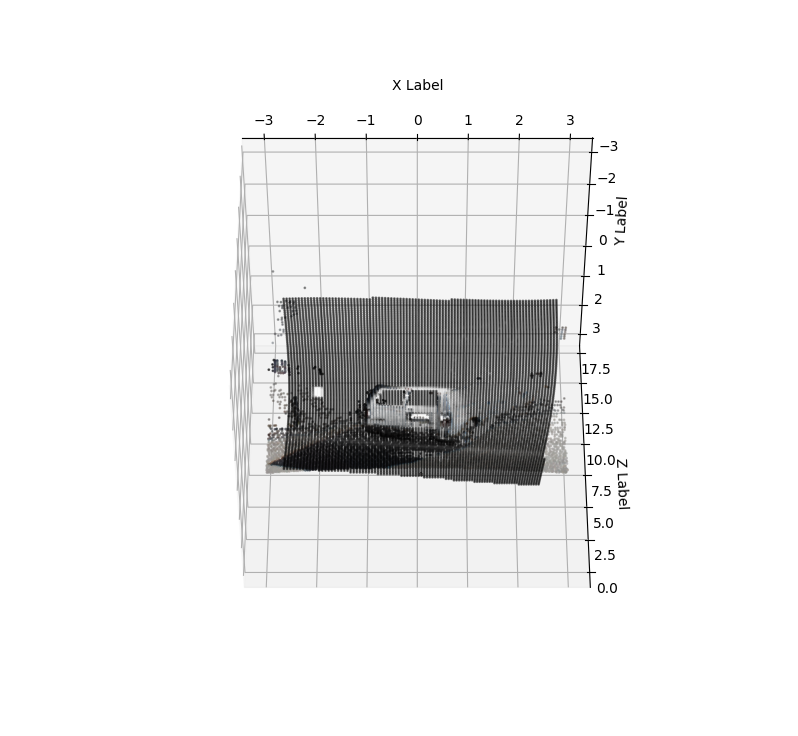

In [10]:
# Generate a Ground Truth Color Pointcloud in Light Curtain NIR Frame
lc_cloud = img_utils.tocloud(torch.tensor(datum.left_depth).unsqueeze(0), img_utils.cv2_to_torchrgb(datum.left_img.astype(np.float32)/255), torch.tensor(datum.large_intr), extr=torch.tensor(datum.M_LC2left))
lc_cloud = lc_cloud[lc_cloud[:,2] > 0.0001]
lc_cloud = lc_cloud[lc_cloud[:,2] < 20]
lc_cloud = lc_cloud[lc_cloud[:,0] < 3]
lc_cloud = lc_cloud[lc_cloud[:,0] > -3]
rgb_vals = lc_cloud[:,3:6]
pos_vals = lc_cloud[:,0:3]

# Plot the cloud
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection = '3d')
ax.set_proj_type('persp')
output = ax.scatter(pos_vals[:,0], pos_vals[:,1], pos_vals[:,2], c = rgb_vals/255.0, s=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.view_init(elev=-40, azim=-90)
fig.gca().autoscale_view()
plt.show()

# Plot the Light Curtain sweep from index 20 to 30
start = 20
end = 30
for i in range(start, end):
    sweep_depth = datum.sweep_arr[i,:,:,0]
    sweep_int = datum.sweep_arr[i,:,:,1]
    
    # Downsample for Speed
    sweep_intr = datum.K_lc.copy()
    scale = 2.
    sweep_intr = sweep_intr / scale
    sweep_depth = cv2.resize(sweep_depth, None, fx=1./scale, fy=1./scale, interpolation = cv2.INTER_NEAREST)
    sweep_int = cv2.resize(sweep_int, None, fx=1./scale, fy=1./scale, interpolation = cv2.INTER_NEAREST)
    sweep_rgb = np.expand_dims(sweep_int, axis=0)
    sweep_rgb = np.repeat(sweep_rgb, 3, axis=0)
    
    # Convert to cloud and plot
    sweep_cloud = img_utils.tocloud(torch.tensor(sweep_depth).unsqueeze(0), torch.tensor(sweep_rgb/255.), torch.tensor(sweep_intr))
    sweep_cloud = sweep_cloud[sweep_cloud[:,2] > 0.0001]
    sweep_cloud = sweep_cloud[sweep_cloud[:,2] < 20]
    sweep_cloud = sweep_cloud[sweep_cloud[:,0] < 3]
    sweep_cloud = sweep_cloud[sweep_cloud[:,0] > -3]
    pos_vals = sweep_cloud[:,0:3]
    rgb_vals = sweep_cloud[:,3:6] / 255.
    out = ax.scatter(pos_vals[:,0], pos_vals[:,1], pos_vals[:,2], c = rgb_vals, s=1, alpha=0.5)
    #ax.view_init(elev=-40+30-i, azim=-90)
    fig.canvas.draw()
    if i != end-1:
        out.remove()

## Visualize the Depthmaps and other Images

<IPython.core.display.Javascript object>


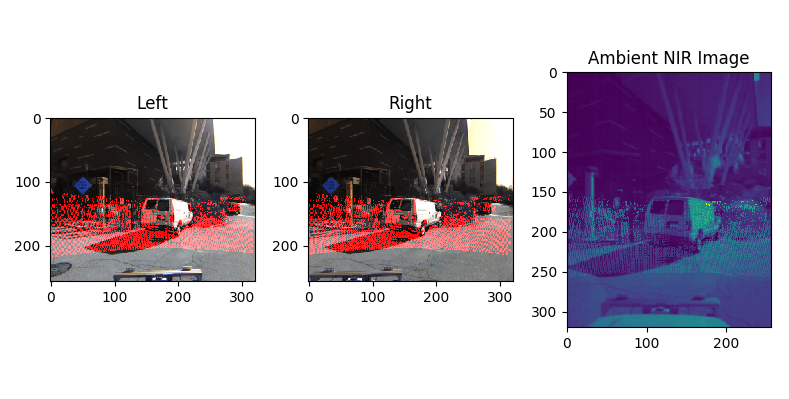

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [23]:
# Visualize Depth Check
left_depth_debug = datum.left_img.copy().astype(np.float32)/255
left_depth_debug[:,:,0] += datum.left_depth
right_depth_debug = datum.right_img.copy().astype(np.float32)/255
right_depth_debug[:,:,0] += datum.right_depth
lc_depth_debug = datum.nir_img.copy().astype(np.float32)/255
lc_depth_debug[:,:] += (datum.lc_depth/25)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 8))
axes[0].set_title("Left")
axes[0].imshow(left_depth_debug)
axes[1].set_title("Right")
axes[1].imshow(right_depth_debug)
axes[2].set_title("Ambient NIR Image")
axes[2].imshow(lc_depth_debug)
fig.tight_layout()

## Visualize the sweep data in various image frames

<IPython.core.display.Javascript object>


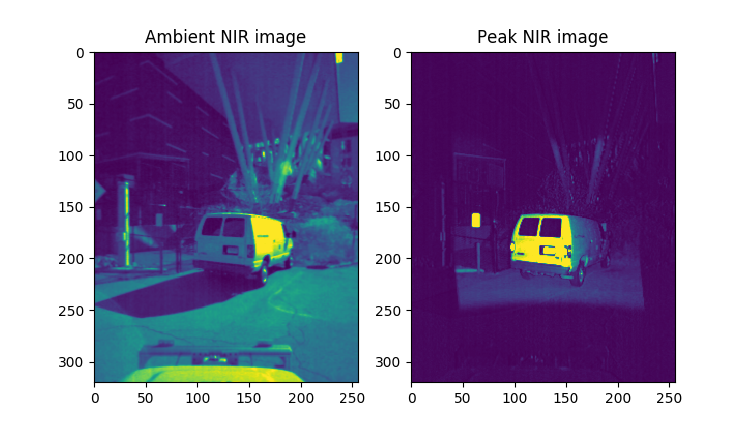

<IPython.core.display.Javascript object>


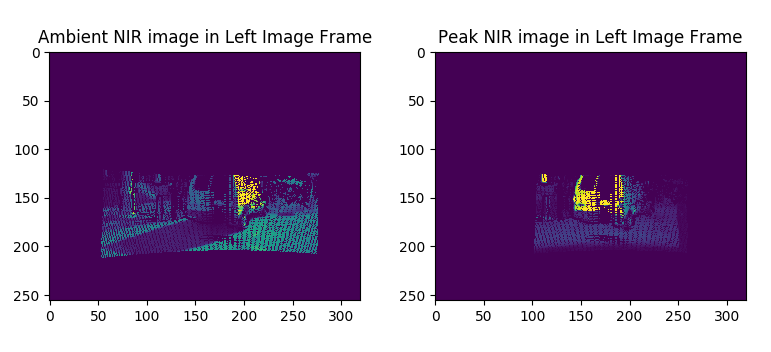

In [22]:
# Compute
start = time.time()
datum.left_feat_int_tensor, datum.left_feat_z_tensor, datum.left_mask_tensor, datum.left_feat_mask_tensor, datum.nir_warped_tensor = img_utils.lcsweep_to_rgbsweep(
    sweep_arr=datum.sweep_arr, dmap_large=datum.left_depth, rgb_intr=datum.large_intr, rgb_size=datum.large_size, lc_intr=datum.K_lc, lc_size=datum.lc_size, M_left2LC=datum.M_left2LC, nir_img=datum.nir_img)

peak_sweep_img = np.max(datum.sweep_arr[:,:,:,1], axis=0)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
axes[0].set_title("Ambient NIR image")
axes[0].imshow(datum.nir_img)
axes[1].set_title("Peak NIR image")
axes[1].imshow(peak_sweep_img)

max_tensor_left, _ = torch.max(datum.left_feat_int_tensor, axis=0)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
axes[0].set_title("Ambient NIR image in Left Image Frame")
axes[0].imshow(datum.nir_warped_tensor.squeeze(0).numpy())
axes[1].set_title("Peak NIR image in Left Image Frame")
axes[1].imshow(max_tensor_left.numpy())

fig.tight_layout()

## Visualize the sweep profile as a graph at various pixels

<IPython.core.display.Javascript object>


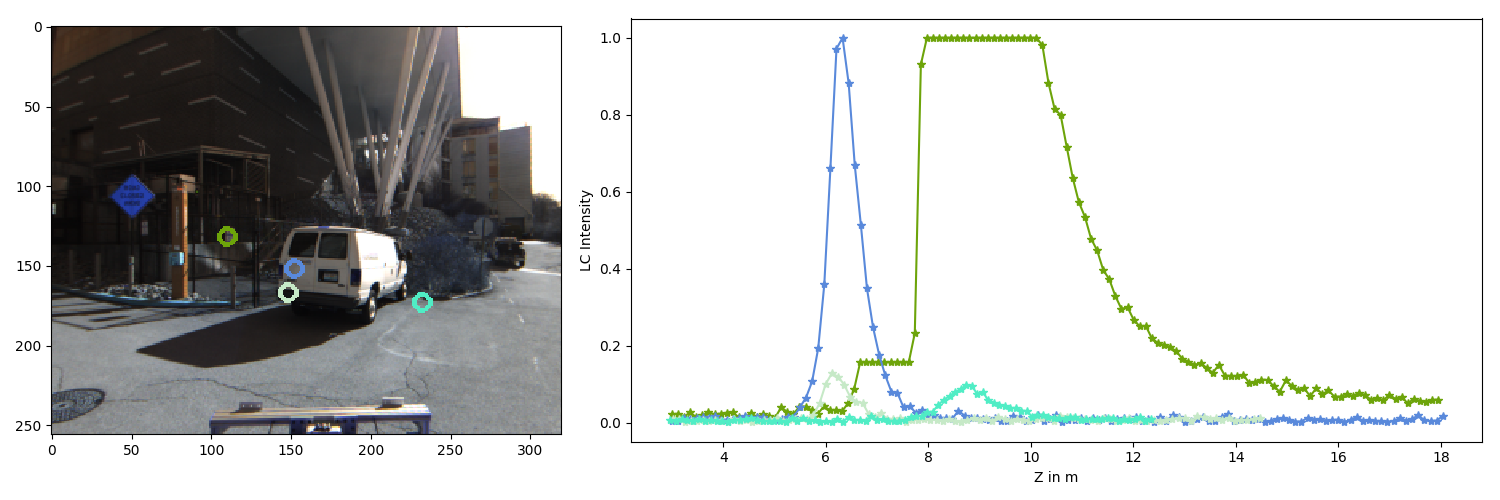

In [20]:
import random
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 8),gridspec_kw={'width_ratios': [3, 5]})


pixels = [(110,132), (152,152), (148,167), (232,173)]
colors = []
left_debug_img = datum.left_img.copy()

for pixel in pixels:
    rgb = (random.random(), random.random(), random.random())
    colors.append(rgb)

for i in range(0, len(pixels)):
    cv2.circle(left_debug_img,pixels[i], 5, (colors[i][0]*255, colors[i][1]*255, colors[i][2]*255), 2)
    
axes[0].imshow(left_debug_img)


for i in range(0, len(pixels)):
    
    # Extract vals
    x = pixels[i][0]; y = pixels[i][1]
    disp_z = datum.left_feat_z_tensor[:,y,x]
    disp_i = datum.left_feat_int_tensor[:,y,x]/255.
    first_nan = np.isnan(disp_z).argmax(axis=0)
    if first_nan:
        disp_z = disp_z[0:first_nan]
        disp_i = disp_i[0:first_nan]
        
    axes[1].plot(disp_z, disp_i, marker='*', c=colors[i])
    plt.ylabel("LC Intensity")
    plt.xlabel("Z in m")
    
    pass

axes[1].figure.set_size_inches(15, 5)
fig.tight_layout()